The goal is:
Help potential HDB resale buyers make informed decisions using clean, well-explored, and easy-to-understand insights.


# 1. Import Libraries & Load Dataset

In [1]:
# To perform EDA and data cleaning, we need pandas, numpy, matplotlib, seaborn.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# Load dataset
df = pd.read_csv("/content/HDB_Resale_Prices.csv")

df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00


# 2. Initial Data Inspection
This step checks for the dataset's completeness and detects early issues such as wrong formats or missing values.

In [4]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194170 entries, 0 to 194169
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                194170 non-null  object 
 1   town                 194170 non-null  object 
 2   flat_type            194170 non-null  object 
 3   block                194170 non-null  object 
 4   street_name          194170 non-null  object 
 5   storey_range         194170 non-null  object 
 6   floor_area_sqm       194170 non-null  float64
 7   flat_model           194170 non-null  object 
 8   lease_commence_date  194170 non-null  int64  
 9   remaining_lease      194170 non-null  object 
 10  resale_price         194170 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.3+ MB


,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
remaining_lease,0


# 3. Clean & Reformat Columns


# 3.1 Convert “remaining_lease” into numeric years.

We need pure numeric years for analysis. Models and visualizations require consistent numeric formatting.

In [5]:
import re

def convert_remaining_lease(x):
    years = re.findall(r'(\d+)\s+year', x)
    months = re.findall(r'(\d+)\s+month', x)

    years = int(years[0]) if years else 0
    months = int(months[0]) if months else 0

    return years + months/12

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_remaining_lease)

# 3.2 Convert Categorical Variables to Proper Types

In [6]:
categorical_cols = ['town', 'flat_type', 'flat_model', 'storey_range', 'month']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# 3.3 Extract Useful Information from Date Column
Temporal analysis helps buyers understand price trends over time.

In [7]:
df['month'] = pd.to_datetime(df['month'])
df['year'] = df['month'].dt.year
df['quarter'] = df['month'].dt.quarter

# 3.4 Compute Lease Age
Older flats generally sell for lower prices, so we want a clean numeric variable.

In [8]:
df['lease_age'] = 2025 - df['lease_commence_date']

# 3.5 Clean Floor Area Column
Just in case there are wrong types:

In [9]:
df['floor_area_sqm'] = pd.to_numeric(df['floor_area_sqm'], errors='coerce')

# 4. Exploratory Data Analysis (EDA)

# 4.1 Price Overview

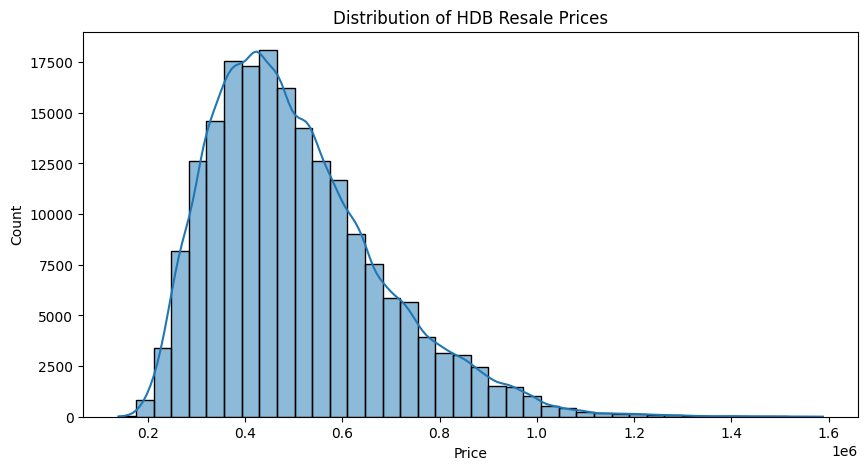

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(df['resale_price'], kde=True, bins=40)
plt.title("Distribution of HDB Resale Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Insights to highlight to customers:
# right-skewed distribution
# Helps buyers understand typical price ranges
# Helps identify outliers (very expensive units)

# 4.2 Structural Attributes vs Resale Price

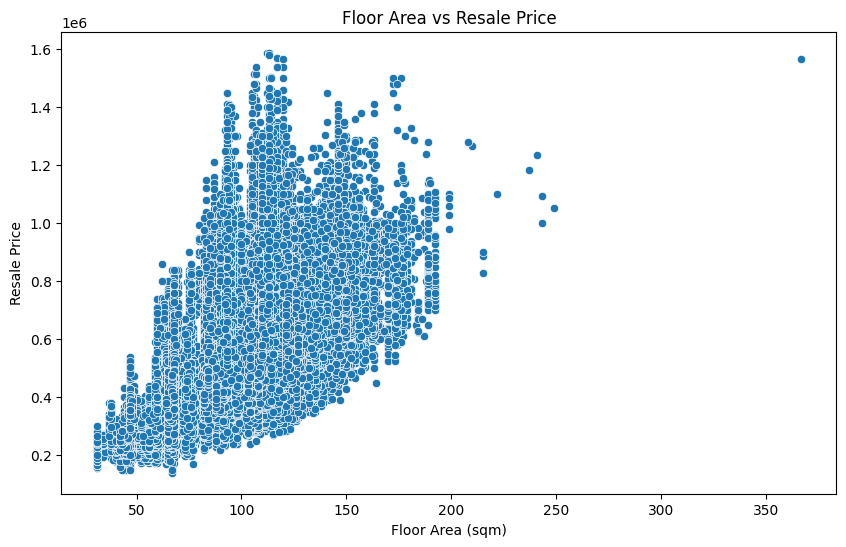

In [11]:
# A. Floor Area vs Price
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price')
plt.title("Floor Area vs Resale Price")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price")
plt.show()

# Interpretation for buyers:
# Larger flats → generally higher price
# But also look for clusters (town effect)

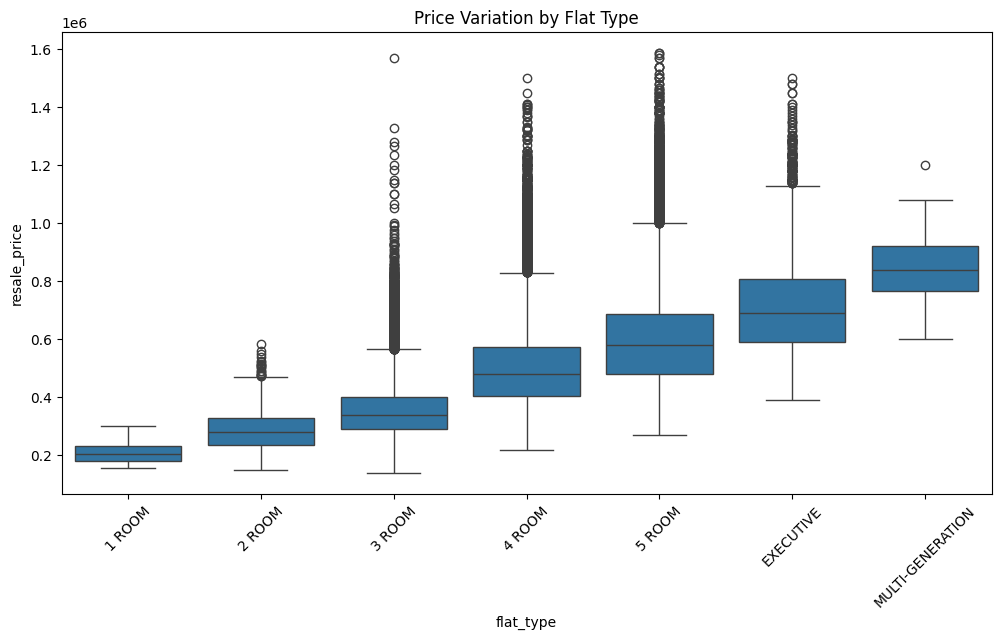

In [12]:
# B. Flat Type vs Price
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='flat_type', y='resale_price')
plt.title("Price Variation by Flat Type")
plt.xticks(rotation=45)
plt.show()

# Interpretation:
# Clear price tiers: 2-Room < 3-Room < 4-Room < 5-Room < Executive
# Helps buyers benchmark their budget

# 4.3 Locational Factors

/tmp/ipython-input-979941824.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  town_price = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(10)


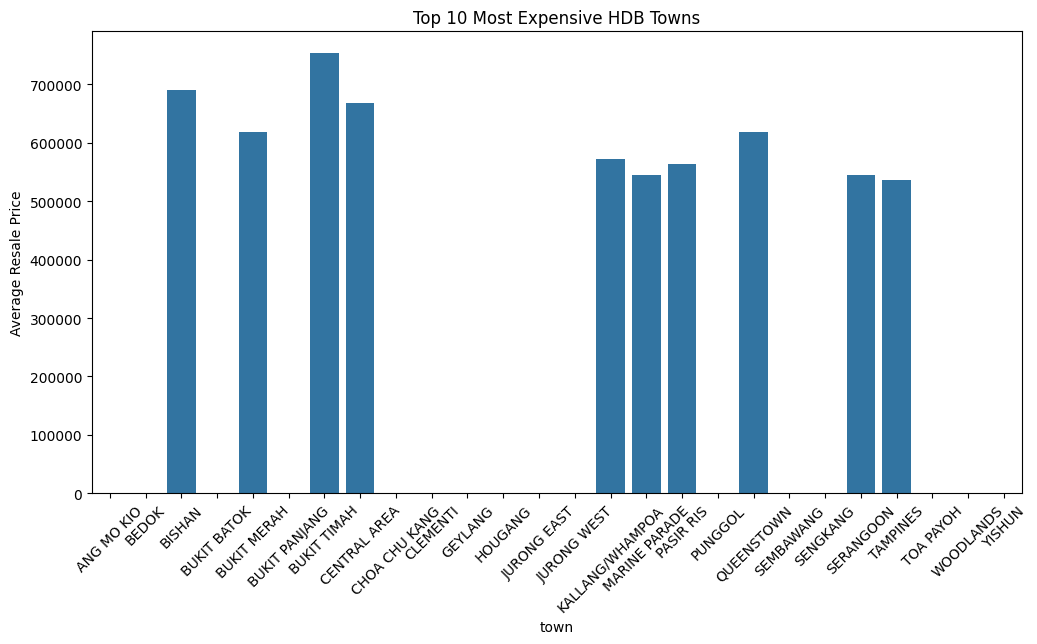

In [13]:
# A. Town vs Price (Top 10 Most Expensive)
town_price = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=town_price.index, y=town_price.values)
plt.title("Top 10 Most Expensive HDB Towns")
plt.ylabel("Average Resale Price")
plt.xticks(rotation=45)
plt.show()

# Interpretation:
# Helps buyers compare where they should buy
# Shows effects of location demand

# 4.4 Temporal Trends Over Time

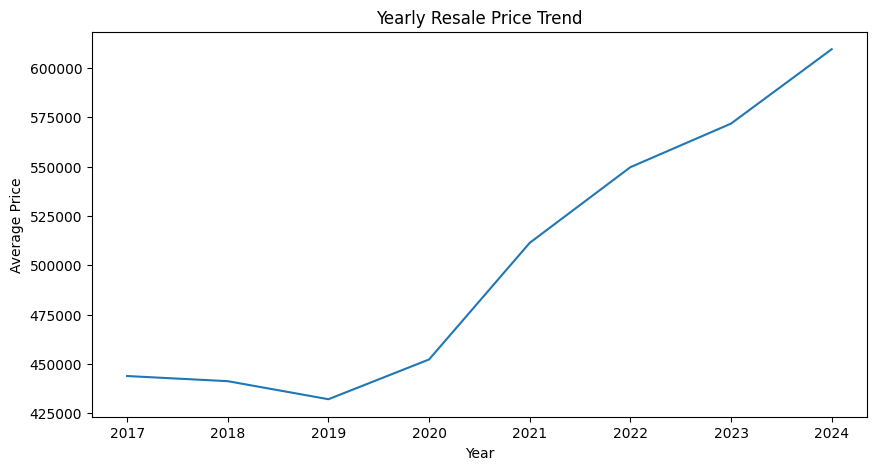

In [14]:
# Yearly Price Trend
yearly = df.groupby('year')['resale_price'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly.index, y=yearly.values)
plt.title("Yearly Resale Price Trend")
plt.ylabel("Average Price")
plt.xlabel("Year")
plt.show()

# Interpretation:
# Buyers can check if market is going up or down
# Helps with timing the purchase

# 4.5 Correlation Heatmap

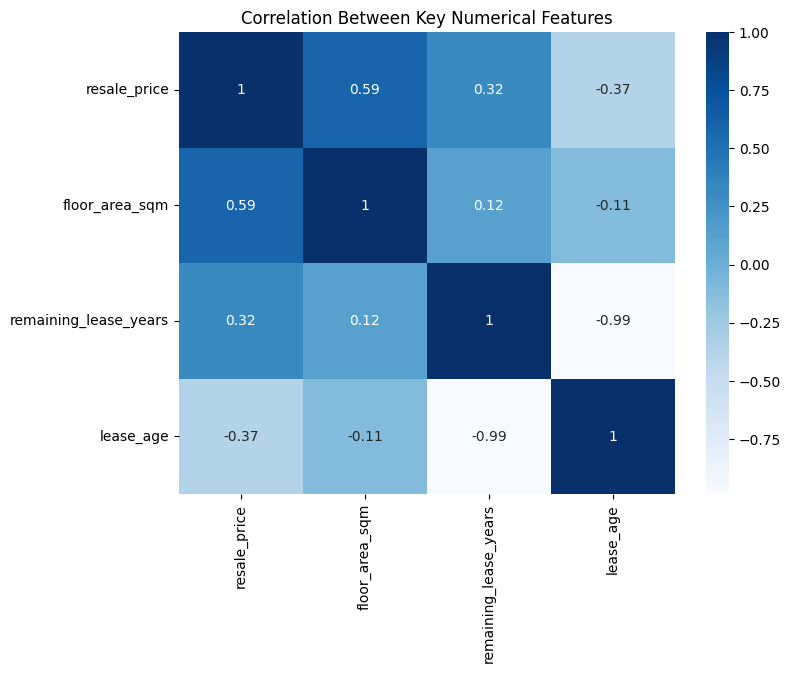

In [15]:
num_df = df[['resale_price', 'floor_area_sqm', 'remaining_lease_years', 'lease_age']]
plt.figure(figsize=(8,6))
sns.heatmap(num_df.corr(), annot=True, cmap='Blues')
plt.title("Correlation Between Key Numerical Features")
plt.show()

# Interpretation:
# Floor area highly correlated with price 0.59
# Remaining lease also important z
# Lease age inversely correlated (older → cheaper)

# 5. Feature Engineering (For Later Modeling)

In [16]:
# Convert categorical to dummy variables:

df_model = pd.get_dummies(df,
                          columns=['town', 'flat_type', 'flat_model', 'storey_range'],
                          drop_first=True)

# Step 1: Prepare Coordinates (Latitude & Longitude)

In [17]:
import requests
import pandas as pd
import time

def geocode_address(address):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    r = requests.get(url).json()

    if r["found"] > 0:
        lat = r["results"][0]["LATITUDE"]
        lon = r["results"][0]["LONGITUDE"]
        return float(lat), float(lon)
    else:
        return None, None

df['lat'] = None
df['lon'] = None

# Create a 'full_address' column by combining 'block' and 'street_name'
df['full_address'] = df['block'] + ' ' + df['street_name']

# Iterate through the new 'full_address' column to get coordinates
for i, address_str in enumerate(df['full_address']):
    lat, lon = geocode_address(address_str)
    df.loc[i, 'lat'] = lat
    df.loc[i, 'lon'] = lon
    time.sleep(0.2)   # API cooldown

# Drop the 'full_address' column if it's no longer needed
df = df.drop(columns=['full_address'])

KeyboardInterrupt: 

In [19]:
import requests
import pandas as pd
import numpy as np
import time

# 1. Function to geocode a full address
def geocode_address(address):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    r = requests.get(url).json()

    if r["found"] > 0:
        lat = r["results"][0]["LATITUDE"]
        lon = r["results"][0]["LONGITUDE"]
        return float(lat), float(lon)
    else:
        return np.nan, np.nan   # use NaN for missing

# Create a 'full_address' column by combining 'block' and 'street_name'
df['full_address'] = df['block'] + ' ' + df['street_name']

# Get unique addresses to avoid redundant API calls (ignore NaN if any)
unique_addresses = df['full_address'].dropna().unique()
print(f"Unique addresses to geocode: {len(unique_addresses)}")

# Build a lookup dictionary: address -> (lat, lon)
address_to_coord = {}

for i, address_str in enumerate(unique_addresses, start=1):
    lat, lon = geocode_address(address_str)
    address_to_coord[address_str] = (lat, lon)

    # Optional: tiny sleep + progress print
    if i % 100 == 0:
        print(f"Geocoded {i} / {len(unique_addresses)} addresses")
    time.sleep(0.1)  # or even lower if API allows

# 4. Map back to the full dataframe
df['lat'] = df['full_address'].map(lambda addr: address_to_coord.get(addr, (np.nan, np.nan))[0])
df['lon'] = df['full_address'].map(lambda addr: address_to_coord.get(addr, (np.nan, np.nan))[1])

# Drop the 'full_address' column if it's no longer needed
df = df.drop(columns=['full_address'])

Unique addresses to geocode: 9598
Geocoded 100 / 9598 addresses
Geocoded 200 / 9598 addresses
Geocoded 300 / 9598 addresses
Geocoded 400 / 9598 addresses
Geocoded 500 / 9598 addresses
Geocoded 600 / 9598 addresses
Geocoded 700 / 9598 addresses
Geocoded 800 / 9598 addresses
Geocoded 900 / 9598 addresses
Geocoded 1000 / 9598 addresses
Geocoded 1100 / 9598 addresses
Geocoded 1200 / 9598 addresses
Geocoded 1300 / 9598 addresses
Geocoded 1400 / 9598 addresses
Geocoded 1500 / 9598 addresses
Geocoded 1600 / 9598 addresses
Geocoded 1700 / 9598 addresses
Geocoded 1800 / 9598 addresses
Geocoded 1900 / 9598 addresses
Geocoded 2000 / 9598 addresses
Geocoded 2100 / 9598 addresses
Geocoded 2200 / 9598 addresses
Geocoded 2300 / 9598 addresses
Geocoded 2400 / 9598 addresses
Geocoded 2500 / 9598 addresses
Geocoded 2600 / 9598 addresses
Geocoded 2700 / 9598 addresses
Geocoded 2800 / 9598 addresses
Geocoded 2900 / 9598 addresses
Geocoded 3000 / 9598 addresses
Geocoded 3100 / 9598 addresses
Geocoded 3200 